In [1]:
%pip install aiohttp fsspec h5py

  Using cached aiohttp-3.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached h5py-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
Using cached aiohttp-3.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
Using cached h5py-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
Usi

## Classifying a phase transition in the XXZ model

In [2]:
import numpy as np

import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce

from numba import jit, njit
from copy import copy, deepcopy

import sys
sys.path.append("..")

import Entangler
import TensorNetwork
import hamiltonians
import uuid
import json

import pennylane as qml
import pennylane.numpy as np

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

/tmp/ipykernel_196/316123068.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
available_data = qml.data.list_datasets()
available_data["qspin"].keys()

dict_keys(['BoseHubbard', 'Ising', 'Heisenberg', 'FermiHubbard'])

### Loading the data

In [3]:
data_Ising = qml.data.load("qspin", 
                           sysname="Ising", 
                           periodicity="closed", 
                           lattice="chain", 
                           layout=["1x8"])

groundstates = [] 
for h_value in range(100):
    groundstates.append(
        np.array(data_Ising[0].ground_states[h_value])
    )
data_groundstates = np.array(groundstates)

labels = [] 
for h_index in range(100):
    h = data_Ising[0].parameters['h'][h_index]
    if h < 1:
        labels += [-1.]
    elif h >= 1:
        labels += [1.]
data_labels = np.array(labels)

In [4]:
cuda = False

In [5]:
n_qubits = int(np.log2(len(data_groundstates[0])))
wire = list(range(n_qubits))

depth_classifier = 6

ent = Entangler.IsingEntangler()
TN_classifier = TensorNetwork.Checkerboard(wire, ent, depth=depth_classifier)


tol = 1e-6

In [6]:
n_qubits

8

### Split the data into train and test

In [7]:
test_size = int(0.2 * len(data_labels))
test_index = np.random.randint(0, len(data_labels), test_size)

test_data = data_groundstates[test_index]
test_labels = data_labels[test_index]

train_data = np.delete(data_groundstates,test_index.tolist(),0)
train_labels = np.delete(data_labels,test_index.tolist(),0)

### Constructing objective functions

In [8]:
if cuda == True:
    dev = qml.device("lightning.gpu",wire)
else:
    dev = qml.device("default.qubit",wire)
    
@qml.qnode(dev)
def circuit(params, weights):
    qml.StatePrep(params, wire)
    TN_classifier.construct_circuit(weights)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7))
    
def variational_classifier(weights, bias, params):
    return circuit(params, weights) + bias

def loss_fn(labels, predictions):
    return sum((labels - predictions)**2)/len(labels)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, train_data, labels):
    predictions = [variational_classifier(weights, bias, params) for params in train_data]
    return loss_fn(labels, predictions)


### Running the machine learning

In [9]:
np.random.seed(0)

weights_init = 0.1 * np.random.randn(TN_classifier.n_params, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
opt = qml.NesterovMomentumOptimizer(0.5)
batch_size = 20

In [10]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(train_labels), (batch_size,))
    data_batch = train_data[batch_index]
    label_batch = train_labels[batch_index]
    
    
    weights, bias = opt.step(cost, weights, bias, train_data=data_batch, labels=label_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, df)) for df in train_data]

    current_cost = cost(weights, bias, train_data, train_labels)
    acc = accuracy(train_labels, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 0.7870500 | Accuracy: 0.7654321
Iter:    2 | Cost: 0.4816283 | Accuracy: 0.8024691
Iter:    3 | Cost: 0.3606780 | Accuracy: 0.8518519
Iter:    4 | Cost: 0.3723217 | Accuracy: 0.9506173
Iter:    5 | Cost: 0.3574567 | Accuracy: 0.8765432
Iter:    6 | Cost: 0.3482608 | Accuracy: 0.9382716
Iter:    7 | Cost: 0.4152803 | Accuracy: 0.7654321
Iter:    8 | Cost: 0.3319303 | Accuracy: 0.9135802
Iter:    9 | Cost: 0.2891459 | Accuracy: 0.9135802
Iter:   10 | Cost: 0.2925622 | Accuracy: 0.9012346
Iter:   11 | Cost: 0.2985510 | Accuracy: 0.9506173
Iter:   12 | Cost: 0.2789505 | Accuracy: 0.9135802
Iter:   13 | Cost: 0.2731527 | Accuracy: 0.9382716
Iter:   14 | Cost: 0.2804912 | Accuracy: 0.9135802
Iter:   15 | Cost: 0.2671785 | Accuracy: 0.9506173
Iter:   16 | Cost: 0.2722791 | Accuracy: 0.9259259
Iter:   17 | Cost: 0.2758976 | Accuracy: 0.9135802
Iter:   18 | Cost: 0.2597849 | Accuracy: 0.9506173
Iter:   19 | Cost: 0.2653360 | Accuracy: 0.9629630
Iter:   20 | Cost: 0.2651838 | 

KeyboardInterrupt: 

### Checking the performance on the test set

In [11]:
predictions_test = [np.sign(variational_classifier(weights, bias, df)) for df in test_data]

acc_test = accuracy(test_labels, predictions_test)

print("Accuracy on test data:", acc_test)

Accuracy on test data: 1.0


In [12]:
%matplotlib inline

preds = []
for i in range(len(data_groundstates)):
    preds.append(variational_classifier(weights, bias, data_groundstates[i]))

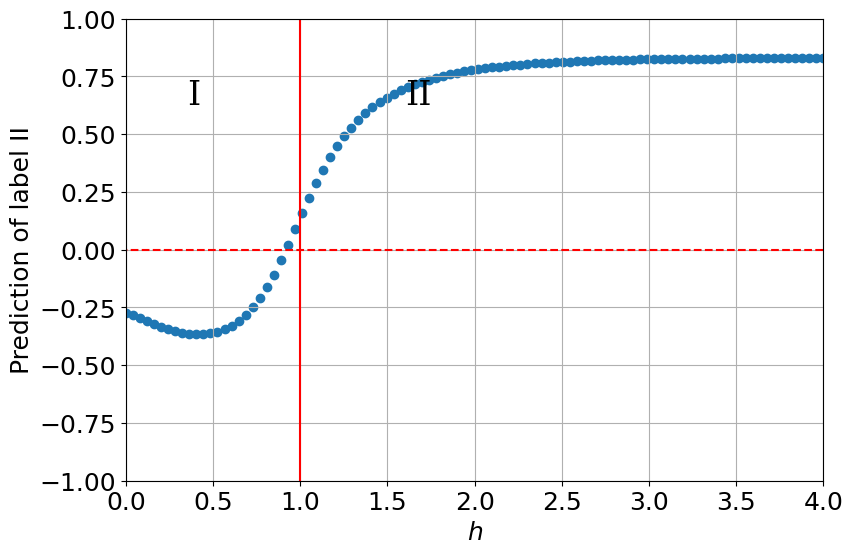

In [14]:
fields = np.array(data_Ising[0].parameters['h'])
plt.scatter(fields, preds)

plt.xlabel(r'$h$')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([-1, 1])
plt.xlim([0, 4])
plt.plot([1, 1], [-1, 1], 'r')
plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
plt.plot([4, 0], [0,0], 'r--')
plt.show()